## Retraining 'eye_tracking' model for subject and predicting eye track (pixel coordinate).

In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from sklearn.utils import shuffle
from joblib import load as jload
from joblib import dump as jdump
import time
import os
import tuning_parameters as tp

In [2]:
# Parameters
TESTING = True
target_folder = "../subjects/"
et_public_scaler_dir = f"../models/eye_tracking/trained/scalers{tp.EYE_TRACKING_MODEL_NUMBER}.bin"
et_public_model_dir = f"../models/eye_tracking/trained/model{tp.EYE_TRACKING_MODEL_NUMBER}"
R_TRAIN = 0.85
N_EPOCHS = 100
PATIENCE = 10
TRAINABLE_LAYERS = 1

In [3]:
if TESTING:
    sampling_fol = "sampling_test data/"
    sampling_pixels_fol = "sampling_test data-pixels/"
else:
    sampling_fol = "sampling data/"
    sampling_pixels_fol = "sampling data-pixels/"
        
subject_dir = target_folder + f"{tp.NUMBER}/"
ibo_subject_scaler_dir = subject_dir + "scalers_in_blink_out.bin"
ibo_subject_model_dir = subject_dir + "model_in_blink_out"

### Retraining 'eye_tracking' model with subject calibration data

In [4]:
et_clb_fol = subject_dir + "eye_tracking data-calibration/"
print(f"\nLoading subject data in {et_clb_fol}")
with open(et_clb_fol + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(et_clb_fol + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(et_clb_fol + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_height, frame_width = x1_load.shape[:-1]
print(f"Samples number: {n_smp}")


Loading subject data in ../subjects/1/eye_tracking data-calibration/
Samples number: 1500


In [5]:
import matplotlib.pyplot as plt

[ 2.8259465   0.17720541 -0.20070962 -2.16536406 -1.24741738 62.53657395
  0.47998068  0.44966942  0.48226577  0.39457735]
[23 12]


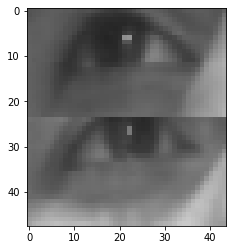

In [6]:
# Displaying data
SAMPLE_NUMBER = 0
print(x2_load[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

#### Getting those data that looking 'in' screen

In [7]:
print("\nNormalizing data...")
x2_chs_inp = x2_load[:, tp.CHOSEN_INPUTS]
scalers_ibo = jload(ibo_subject_scaler_dir)
x1_scaler_ibo, x2_scaler_ibo = scalers_ibo
x1 = x1_load / x1_scaler_ibo
x2 = x2_scaler_ibo.transform(x2_chs_inp)


Normalizing data...


F:\Education_Study\University\MSC\Thesis\EyeTracker\venv\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
print("\nLoading in_blink_out model...")
model_ibo = load_model(ibo_subject_model_dir)
print(model_ibo.summary())


Loading in_blink_out model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
_______________________________________________________________

In [9]:
print("\nPredicting those data that looking 'in' screen.")
x = [x1, x2]
yhat_ibo = model_ibo.predict(x).argmax(1)


Predicting those data that looking 'in' screen.


In [10]:
# Choosing those data
x1_new = []
x2_new = []
y_new = []
for (x10, x20, y0, yht0) in zip(x1_load, x2_load, y_load, yhat_ibo):
    if True: # yht0 != 1:
        x1_new.append(x10)
        x2_new.append(x20)
        y_new.append(y0)

x1_new = np.array(x1_new)
x2_new = np.array(x2_new)
y_new = np.array(y_new)
n_smp_new = x1_new.shape[0]
print(f"New samples: {n_smp_new}")

New samples: 1500


### Preparing modified calibration data to feeding in eye_tracking model

In [11]:
print("\nNormalizing modified calibration data to feeding in eye_tracking model...")
x2_chs_inp_new = x2_new[:, tp.CHOSEN_INPUTS]
scalers_et = jload(et_public_scaler_dir)
x1_scaler_et, x2_scaler_et, _ = scalers_et

x1_nrm = x1_new / x1_scaler_et
x2_nrm = x2_scaler_et.transform(x2_chs_inp_new)

y_scalers_et = y_new.max(0)
y_nrm = y_new / y_scalers_et

scalers_et[2] = y_scalers_et
jdump(scalers_et, subject_dir + "scalers_eye_tracking.bin")


Normalizing modified calibration data to feeding in eye_tracking model...


F:\Education_Study\University\MSC\Thesis\EyeTracker\venv\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


['../subjects/1/scalers_eye_tracking.bin']

In [12]:
# Shuffling and splitting data to train and test
x1_shf, x2_shf, yx_shf, yy_shf = shuffle(x1_nrm, x2_nrm, y_nrm[:, 0], y_nrm[:, 1])

n_train = int(R_TRAIN * n_smp_new)
n_test = n_smp_new - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
yx_train, yy_train = yx_shf[:n_train], yy_shf[:n_train]
yx_test, yy_test = yx_shf[n_train:], yy_shf[n_train:]

x_train = [x1_train, x2_train]
x_test = [x1_test, x2_test]

print(x1_train.shape, x1_test.shape, yx_train.shape, yx_test.shape,
      x2_train.shape, x2_test.shape, yy_train.shape, yy_test.shape)

(1275, 48, 44, 1) (225, 48, 44, 1) (1275,) (225,) (1275, 7) (225, 7) (1275,) (225,)


In [13]:
# Callback for training
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [14]:
print("Loading public eye_tracking models...")
model_x = load_model(et_public_model_dir + "_x")
model_y = load_model(et_public_model_dir + "_y")
# print(model1.summary())

Loading public eye_tracking models...


In [15]:
for (layer1, layer2) in zip(model_x.layers[:-TRAINABLE_LAYERS], model_y.layers[:-TRAINABLE_LAYERS]):
    layer1.trainable = False
    layer2.trainable = False

print(model_x.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 48, 44, 16)   416         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 24, 22, 16)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 24, 22, 32)   12832       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [16]:
print("\nStart of training for model 1 (x-pixels)")
results_x = model_x.fit(x_train,
                        yx_train,
                        validation_data=(x_test, yx_test),
                        epochs=N_EPOCHS,
                        callbacks=cb)
print("End of training")


Start of training for model 1 (x-pixels)
Epoch 1/100
40/40 [==============================] - 2s 47ms/step - loss: 0.0419 - val_loss: 0.0364
Epoch 2/100
40/40 [==============================] - 2s 57ms/step - loss: 0.0309 - val_loss: 0.0237
Epoch 3/100
40/40 [==============================] - 3s 63ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 4/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0171 - val_loss: 0.0160
Epoch 5/100
40/40 [==============================] - 2s 44ms/step - loss: 0.0159 - val_loss: 0.0163
Epoch 6/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0143 - val_loss: 0.0132
Epoch 7/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 8/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 9/100
40/40 [==============================] - 2s 45ms/step - loss: 0.0115 - val_loss: 0.0143
Epoch 10/100
40/40 [==============================] - 2s 4

In [17]:
print("\nStart of training for model 2 (y-pixels)")
results_y = model_y.fit(x_train,
                        yy_train,
                        validation_data=(x_test, yy_test),
                        epochs=N_EPOCHS,
                        callbacks=cb)
print("End of training")


Start of training for model 2 (y-pixels)
Epoch 1/100
40/40 [==============================] - 2s 47ms/step - loss: 0.3289 - val_loss: 0.2603
Epoch 2/100
40/40 [==============================] - 2s 46ms/step - loss: 0.1738 - val_loss: 0.0944
Epoch 3/100
40/40 [==============================] - 2s 45ms/step - loss: 0.0858 - val_loss: 0.0554
Epoch 4/100
40/40 [==============================] - 2s 44ms/step - loss: 0.0604 - val_loss: 0.0463
Epoch 5/100
40/40 [==============================] - 2s 51ms/step - loss: 0.0510 - val_loss: 0.0499
Epoch 6/100
40/40 [==============================] - 2s 44ms/step - loss: 0.0434 - val_loss: 0.0344
Epoch 7/100
40/40 [==============================] - 2s 43ms/step - loss: 0.0411 - val_loss: 0.0378
Epoch 8/100
40/40 [==============================] - 2s 47ms/step - loss: 0.0363 - val_loss: 0.0287
Epoch 9/100
40/40 [==============================] - 2s 44ms/step - loss: 0.0313 - val_loss: 0.0505
Epoch 10/100
40/40 [==============================] - 2s 4

In [18]:
print("\nSaving models...")
model_x.save(subject_dir + "model_eye_tracking_x")
model_y.save(subject_dir + "model_eye_tracking_y")


Saving models...
INFO:tensorflow:Assets written to: ../subjects/1/model_eye_tracking_x\assets
INFO:tensorflow:Assets written to: ../subjects/1/model_eye_tracking_y\assets


In [19]:
# Predicting outputs for train and test data
yx_hat_train = model_x.predict(x_train).reshape((n_train,))
yx_hat_test = model_x.predict(x_test).reshape((n_test,))
yy_hat_train = model_y.predict(x_train).reshape((n_train,))
yy_hat_test = model_y.predict(x_test).reshape((n_test,))

yx_hat_train[yx_hat_train < 0] = 0
yx_hat_test[yx_hat_test < 0] = 0
yy_hat_train[yy_hat_train < 0] = 0
yy_hat_test[yy_hat_test < 0] = 0

Train
(1168, 1329)
(1158, 1344)
Test
(1550, 1109)
(1561, 1074)


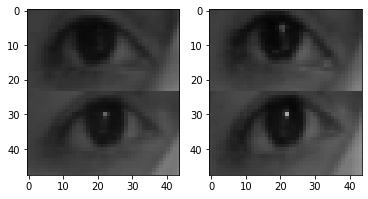

In [20]:
# Displaying data
NUM = 0
print("Train")
sample_train = (int(yx_train[NUM] * y_scalers_et[0]),
                int(yy_train[NUM] * y_scalers_et[1]))
sample_hat_train = (int(yx_hat_train[NUM] * y_scalers_et[0]),
                    int(yy_hat_train[NUM] * y_scalers_et[1]))
print(sample_train)
print(sample_hat_train)

print("Test")
sample_test = (int(yx_test[NUM] * y_scalers_et[0]),
                int(yy_test[NUM] * y_scalers_et[1]))
sample_hat_test = (int(yx_hat_test[NUM] * y_scalers_et[0]),
                    int(yy_hat_test[NUM] * y_scalers_et[1]))
print(sample_test)
print(sample_hat_test)

_, ax = plt.subplots(1,2)
ax[0].imshow((x1_train[NUM] * x1_scaler_et).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)
ax[1].imshow((x1_test[NUM] * x1_scaler_et).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)

### Getting sampling data that looking 'in' screen

In [21]:
sampling_dir = subject_dir + sampling_fol
print(f"\nLoading subject sampling data in {sampling_dir}")

with open(sampling_dir + "t.pickle", "rb") as f:
    t_smp_load = pickle.load(f)
with open(sampling_dir + "x1.pickle", "rb") as f:
    x1_smp_load = pickle.load(f)
with open(sampling_dir + "x2.pickle", "rb") as f:
    x2_smp_load = pickle.load(f)
if TESTING:
    with open(sampling_dir + "y.pickle", "rb") as f:
        y_smp_load = pickle.load(f)

n_smp= t_smp_load.shape[0]
print(f"Number of sampling data : {n_smp}")


Loading subject sampling data in ../subjects/1/sampling_test data/
Number of sampling data : 180


In [22]:
# Normalizing Sampling data for 'in_blink_out' model
x2_smp_chs_inp = x2_smp_load[:, tp.CHOSEN_INPUTS]
x1_smp = x1_smp_load / x1_scaler_ibo
x2_smp = x2_scaler_ibo.transform(x2_smp_chs_inp)
x_smp = [x1_smp, x2_smp]

In [23]:
print("\nPredicting those data that looking 'in' screen...")
y_hat_smp_ibo = model_ibo.predict(x_smp).argmax(1)


Predicting those data that looking 'in' screen...


### Predicting eye track for samling data in pixels.

In [24]:
# Normalizing Sampling data for 'eye_tracking' model
x2_smp_load_chs_inp = x2_smp_load[:, tp.CHOSEN_INPUTS]
x1_smp_nrm = x1_smp_load / x1_scaler_et
x2_smp_nrm = x2_scaler_et.transform(x2_smp_load_chs_inp)
x_smp = [x1_smp_nrm, x2_smp_nrm]

In [25]:
print("\nPredicting sampling data...")
yx_hat_smp = np.expand_dims(model_x.predict(x_smp).reshape((n_smp,)), 1)
yy_hat_smp = np.expand_dims(model_y.predict(x_smp).reshape((n_smp,)), 1)

yx_hat_smp[yx_hat_smp < 0] = 0
yy_hat_smp[yy_hat_smp < 0] = 0

y_hat = (np.concatenate([yx_hat_smp, yy_hat_smp], 1) * y_scalers_et).astype(np.uint32)


Predicting sampling data...


In [26]:
sampling_pixels_dir = subject_dir + sampling_pixels_fol
if not os.path.exists(sampling_pixels_dir):
    os.mkdir(sampling_pixels_dir)

with open(sampling_pixels_dir + "y_hat_smp_ibo.pickle", 'wb') as f:
    pickle.dump(y_hat_smp_ibo, f)
with open(sampling_pixels_dir + "t.pickle", 'wb') as f:
    pickle.dump(t_smp_load, f)
with open(sampling_pixels_dir + "y_hat.pickle", 'wb') as f:
    pickle.dump(y_hat, f)
if TESTING:
    with open(sampling_pixels_dir + "y.pickle", 'wb') as f:
        pickle.dump(y_smp_load, f)
print("\nPixel data saved!!")


Pixel data saved!!
